## 深度神经网络批归一化

### 1. 导入需要的库

In [25]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf

#### 1.1 打印版本

In [26]:
for module in keras, pd, np, tf, mpl, sklearn:
    print(module.__name__, module.__version__)

tensorflow.keras 2.4.0
pandas 1.3.3
numpy 1.18.5
tensorflow 2.3.0
matplotlib 3.4.2
sklearn 1.0


### 2. 处理数据集

#### 2.1 导入数据

- mnist数据集 : https://docs.pythontab.com/tensorflow/tutorials/mnist_beginners/#mnist

In [27]:
# 读取tf自带的数据集
fashion_mnist = tf.keras.datasets.fashion_mnist
# 加载数据
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 拆分训练集和验证集的数据
# 共60000张图片, 前5000张为验证集,后面都是测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [28]:
print(np.max(x_train), np.min(x_train))

255 0


In [29]:
# 数据归一化 : x - means / std(方差)

from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()
# 对训练集和验证集做归一化, 另外 验证集归一化的时候需要训练集的均值和方差
# fit_transformer 输入值是二维矩阵, 另外 fit_transformer 会记录训练时的均值和方差
# x_train : [None, 28, 28] => [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.fit_transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

In [30]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


#### 2.2 展示数据

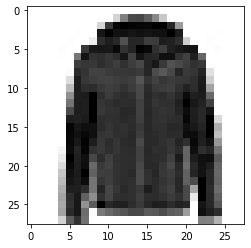

In [31]:
# 数据集都是向量数据, 直接输出无法显示图片, 需要借用matplotlib显示图片
def show_single_image(img_arr):
    # cmp 指的是数据类型
    plt.imshow(img_arr, cmap="binary")
    plt.show()


# 展示图片
show_single_image(x_train[0])

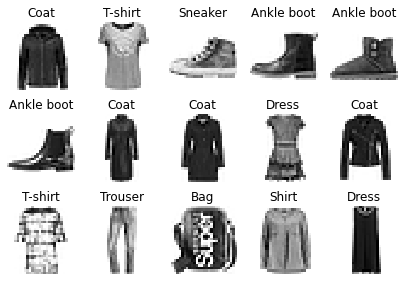

In [32]:
# 展示所有种类的数据
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    # 断言, 判断x_data 和 y_data是否相等
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)

    # 创建画板
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    # 展示不同种类的图像
    for row in range(n_rows):
        for col in range(n_cols):
            # 获取索引
            index = n_cols * row + col
            # plt.subplot 用于绘制子图, 参考 : https://www.cnblogs.com/cgmcoding/p/13279406.html
            plt.subplot(n_rows, n_cols, index + 1)
            # interpolation 缩放图片时使用的方法
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest")
            # 关闭坐标系
            plt.axis('off')
            # 设置标题
            plt.title(class_names[y_data[index]])


class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

### 3. 模型搭建

- Flatten : 输入层, Flatten 将 多维向量展平为一维向量
- Dense :
    1. 实现操作: output = activation(dot(input, kernel) + bias)
    2. 其中 activation 是作为激活参数传递的逐元素激活函数, kernel 是层创建的权重矩阵, bias 是创建的偏置向量

- 激活函数 :
    1. relu : y = max(0, x)
    2. softmax : 将向量变成概率分布 => x = [x1, x2, x3] -> y = [e^x1 / sum, e^x2 / sum, e^x3 / sum], e^x1 + e^x2 +e^x3 = sum

#### 3.1 实现批归一化
- 只需要把归一化的层放到激活函数的后面即可
    1. model.add(keras.layers.BatchNormalization())
- 将批归一化放到激活函数的前面
    1. model.add(keras.layers.Dense(100))
    2. model.add(keras.layers.BatchNormalization())
    3. model.add(keras.layers.Activation('relu'))
- 批归一化可以缓解梯度消失的问题


In [33]:
# 创建模型
# model = keras.models.Sequential()
model = keras.models.Sequential()
# 添加输入层, Flatten 将 多维向量展平为一维向量
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 添加一个20层的深度神经网络
# 使用for 循环添加神经网络
for _ in range(20):
    model.add(keras.layers.Dense(units=64, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    # 将批归一化放到激活函数的后面
    """
        model.add(keras.layers.Dense(100))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
    """

# 添加最终输出层
model.add(keras.layers.Dense(units=10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=[keras.metrics.Accuracy()])

In [34]:
# 查看模型的层数
model.layers

In [35]:
# 展示模型的架构, 以及可训练参数
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                50240     
_________________________________________________________________
batch_normalization_40 (Batc (None, 64)                256       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_41 (Batc (None, 64)                256       
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_42 (Batc (None, 64)               

- 全连接层参数计算
- [None, 784] * W + b(偏置) -> [None, 300] => W (参数) shape = [784, 300], b = [300] => 784 * 300 + 300 = 235500

#### 3.2 添加回调函数

- TensorBord : 查看模型训练期间的参数以及计算图
    1. tensorboard --logdir=./tf_keras_code/callbacks 可以查看TensorBoard网页
- Earlystopping : 设置终止训练的条件
- ModelCheckpoint : 保存模型

In [36]:
# 训练模型
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid))

Epoch 1/10


ValueError: in user code:

    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\engine\training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:409 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\keras\metrics.py:3208 accuracy  **
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 1) are incompatible


In [ ]:
print(history.history)

In [ ]:
# GPU 和 CPU 训练的结果有很大不同
history.history

In [ ]:
# 绘制图像
def plt_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0, 1)
    # 展示图像
    plt.show()

plt_learning_curves(history)

In [ ]:
# 在测试集上评估
model.evaluate(x_test_scaled, y_test)